# Time Series Analysis: Global CO<sub>2</sub> Concentration
## Part 1: Basic ARIMA and SARIMA Modeling

Carbon dioxide and other so-called "greenhouse gases" play a central role in regulating the temperature of the Earth. Several different processes affect the amount of CO<sub>2</sub> in the atmosphere, including:

- photosynthesis
- fossil fuel combustion
- gaseous exchange with the ocean

This notebook will gather information from the 

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style='ticks')

# Exploratory Data Analysis

## Load and Preprocess Data

In [67]:
co2 = pd.read_csv('./data/co2-ppm-daily_csv.csv')
co2.head()

,date,value
0,1958-03-30,316.16
1,1958-03-31,316.40
2,1958-04-02,317.67
3,1958-04-03,317.76
4,1958-04-04,317.09


Immediately we can tell there is missing data, as there is no entry for April 1, 1958. We can re-index the DataFrame using all dates in the range.

In [68]:
co2['date'] = pd.to_datetime(co2['date'], format='%Y-%m-%d')

co2.set_index('date', inplace=True)
co2.head()

,value
date,
1958-03-30,316.16
1958-03-31,316.40
1958-04-02,317.67
1958-04-03,317.76
1958-04-04,317.09


In [71]:
date_index = pd.date_range(start=co2.index[0], end=co2.index[-1])
co2 = co2.reindex(date_index, fill_value = np.nan)
co2.head()

,value
1958-03-30,316.16
1958-03-31,316.40
1958-04-01,NaN
1958-04-02,317.67
1958-04-03,317.76


In [74]:
co2['value'].isna().sum() / len(co2)

0.1390172383152657

Approximately 14% of the days listed do not have a measured CO2 value.

In [59]:
co2['year'] = co2.index.year
co2['month'] = co2.index.month
co2['day'] = co2.index.day

In [62]:
co2.head()

,value,year,month,day
1958-03-30,316.16,1958,3,30
1958-03-31,316.40,1958,3,31
1958-04-01,NaN,1958,4,1
1958-04-02,317.67,1958,4,2
1958-04-03,317.76,1958,4,3


In [66]:
co2[(co2['year'] == 1959) & (co2['month'] == 3)]['value'].mean()

316.7845

In [28]:
co2_means = pd.DataFrame(columns=['year', 'month', 'value'])

rows = []

for year in co2['year'].unique():
    for month in co2[co2['year'] == year]['month'].unique():
        co2_mean_row = {}
        co2_mean_row['year'] = year
        co2_mean_row['month'] = month
        co2_mean_row['value'] = co2[(co2['year'] == year) & (co2['month'] == month)]['value'].mean()
        rows.append(co2_mean_row)
        
co2_means.append(rows)

,year,month,value
0,1958,3,316.280000
1,1958,4,317.365000
2,1958,5,317.471111
3,1958,7,315.642143
4,1958,8,315.032000
...,...,...,...
730,2019,7,411.814348
731,2019,8,409.985862
732,2019,9,408.537586
733,2019,10,408.523333


In [26]:
co2_means.head()

,year,month,value


In [4]:
co2['rolling_mean_mo'] = co2['value'].rolling(30).mean()
co2['rolling_mean_yr'] = co2['value'].rolling(365).mean()
co2['rolling_std'] = co2['value'].rolling(365).std()

In [5]:
co2.head()

,value,year,month,day,rolling_mean_mo,rolling_mean_yr,rolling_std
date,,,,,,,
1958-03-30,316.16,1958,3,30,NaN,NaN,NaN
1958-03-31,316.40,1958,3,31,NaN,NaN,NaN
1958-04-02,317.67,1958,4,2,NaN,NaN,NaN
1958-04-03,317.76,1958,4,3,NaN,NaN,NaN
1958-04-04,317.09,1958,4,4,NaN,NaN,NaN


## Plot Time Series

Visualizing our time series allows us to make rough estimates about the trend, seasonality, heteroskedacity, and stationarity:

- **Trend**: long-term increase or decrease in value
- **Seasonality**: periodicity; whether the data has patterns that repeat over fixed periods of time (month, quarter, year, etc.)
- **Heteroskedacity**: whether variance increases or decreases as a function of time
- **Stationarity**: whether mean and variance is constant over time

## Test for Stationarity

In the case that stationarity is more ambiguous, we can perform the Augmented Dickey-Fuller test to hypothesis test for non-stationarity.

In [97]:
co2['pct_change'] = co2['value'].pct_change()

In [100]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

In [101]:
adfuller(co2['pct_change'])[1]

MissingDataError: exog contains inf or nans

In [24]:
# Run ADF test on original (non-differenced!) data.
adfuller(co2['value'])[1]

0.7688080774710268

This large *p*-value indicates non-stationarity in our data (but this step would be necessary in cases where stationarity is not immediately obvious).

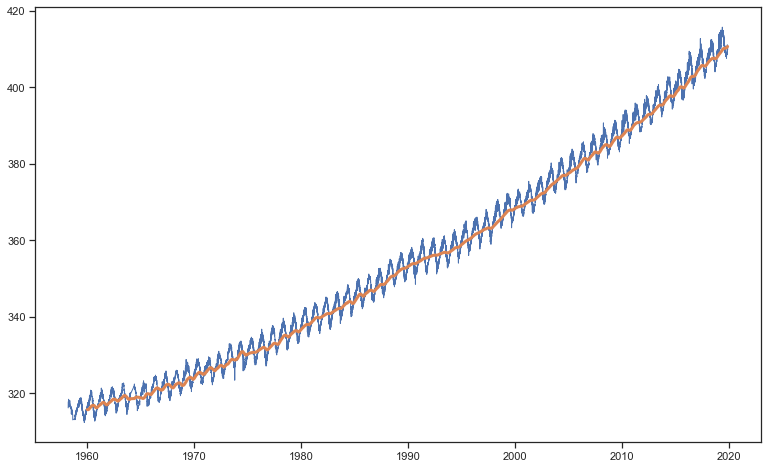

In [57]:
plt.figure(figsize=(13,8))

plt.plot(co2['value'], linewidth=1)
plt.plot(co2['rolling_mean'], linewidth=3)

- **Trend**: increasing, mostly linear
- **Seasonality**: peaks every 12 months
- **Heteroskedacity**: does not appear to be heteroskedastic
- **Stationarity**: definitely not

# Box–Jenkins Method

The Box–Jenkins method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find a best-fit model using past values of a time series.

The steps are:

1. Model identification and model selection
2. Parameter estimation
3. Model checking

## Model Identification and Model Selection

### Assessing Stationarity

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

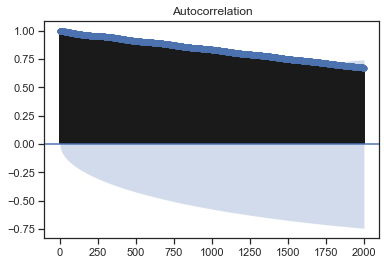

In [82]:
plot_acf(co2['value'], lags=2000);

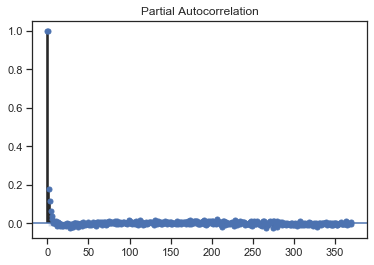

In [84]:
plot_pacf(co2['value'], lags=370);

- **Trend**: lags 1 and 2 are strongly correlated, indicating trend
- **Seasonality**: every 12 months has the strongest autocorrelations. 

Due to the high autocorrelation, we most likely need to transform our data to achieve stationarity. We can do this by taking differentials.

### Choosing Parameter _d_: Differencing for Stationarity

Our model order _d_ is chosen by the number of differences we take on our data to achieve **stationarity**.

In [85]:
co2['value_d1'] = co2['value'].diff(1)

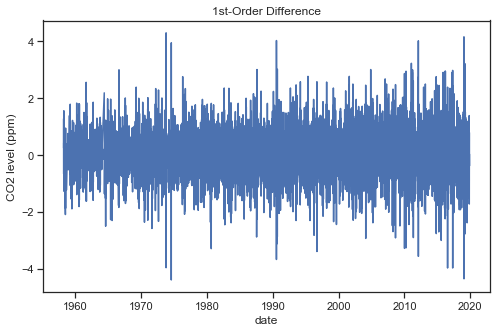

In [86]:
plt.figure(figsize=(8,5))
ax = sns.lineplot(x = co2.index,
             y = co2['value_d1'])

ax.set(title='1st-Order Difference')
ax.set(ylabel='CO2 level (ppm)');

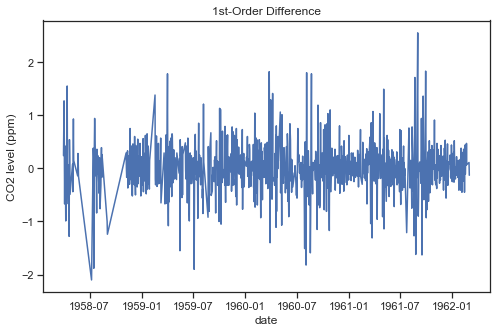

In [88]:
plt.figure(figsize=(8,5))
ax = sns.lineplot(x = co2.index[:1000],
             y = co2['value_d1'][:1000])

ax.set(title='1st-Order Difference')
ax.set(ylabel='CO2 level (ppm)');

In [90]:
adfuller(co2['value_d1'].dropna())[1]

1.2840149338713592e-24

Since _p_ for the augmented Dickey Fuller test is much less than 0.05, our data achieves stationarity after a first-order difference; therefore, parameter _d_ has a value of `1`.

### Choosing Parameter _q_: Determining Moving Average (MA) Order

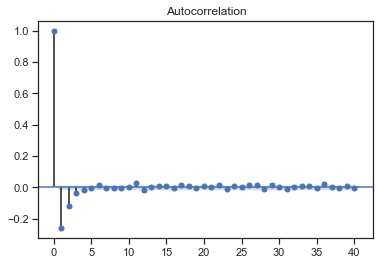

In [93]:
plot_acf(co2['value_d1'].dropna(), lags=40);

We should still try to remove seasonality from our data to see if that improves the stationarity, however. It appears there is a 12-month seasonal fluctuation.

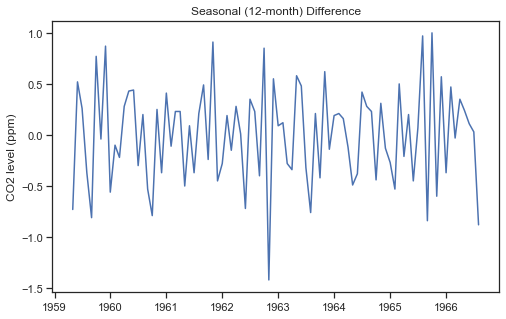

In [278]:
co2['interpolated_s12'] = co2['interpolated_d1'].diff(12)

plt.figure(figsize=(8,5))
ax = sns.lineplot(x = co2.index[:101],
             y = co2['interpolated_s12'][:101])

ax.set(title='Seasonal (12-month) Difference')
ax.set(ylabel='CO2 level (ppm)');

In [279]:
adfuller(co2['interpolated_s12'].dropna())[1]

1.366543075329438e-19

The AR component describes data that use previous observations as predictors and has long-term stability.

We want to look for positive correlations in the *partial* autocorrelations (PACF).

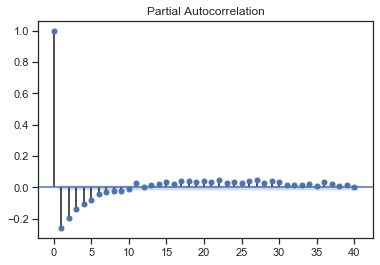

In [94]:
plot_pacf(co2['value_d1'].dropna(), lags=40);

From the PACF, we see  

- if lag 1 is positive, then choose the highest lag that is still positive.
- since lag 2 is negative, then we select lag 1, therefore _p_ has a value of 1.

### Choosing Parameter _q_: Determining Moving Average (MA) Order

The MA component smooths out data that may have short-term fluctuations.

We want to look for lags that are positive and significant. 

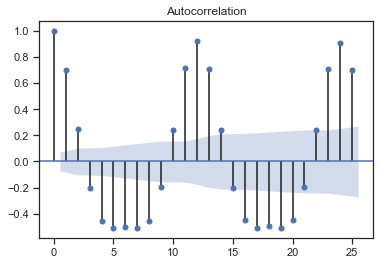

In [276]:
plot_acf(co2['interpolated_d1'].dropna(), lags=25);

From the ACF, we could choose a value of 0?

- there is no sharp drop-off
- lag-1 is not negative

## Akaike Information Criteron (AIC) with Small Sample Correction

In [280]:
from statsmodels.tsa.arima_model import ARIMA

In [281]:
X_train, X_test, y_train, y_test = train_test_split(co2.index,
                                                    co2['interpolated'],
                                                    test_size = 0.3,
                                                    shuffle = False)

In [282]:
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (1,2,0)) 

In [283]:
fitted = model.fit()

In [284]:
fitted.aict

1323.2382152507403

## Fit a Seasonal ARIMA Model

ARIMA is a powerful method but it does not account for seasonal data, and atmospheric CO2 concentration is highly seasonal. So we will be using SARIMA (although the module is called SARIMAX because it supports eXogenous variables as well.

In [213]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

We take the orders _p_, _d_, and _q_ from earlier. 

In [256]:
sarima = SARIMAX(endog = y_train.astype(float).dropna(),
                 order = (1, 1, 0),
                 seasonal_order = (1, 0, 0, 12))

model = sarima.fit()

In [204]:
print(X_test[0])
print(X_test[-1])

2000-07-31 00:00:00
2018-09-30 00:00:00


In [245]:
preds = model.predict(start=datetime(2000, 7, 31),
                      end=datetime(2018, 9, 30))
preds

2000-07-31    370.676878
2000-08-31    368.284465
2000-09-30    366.261603
2000-10-31    366.803712
2000-11-30    368.099132
                 ...    
2018-05-31    387.076323
2018-06-30    387.134349
2018-07-31    386.639623
2018-08-31    385.482783
2018-09-30    384.504638
Freq: M, Length: 219, dtype: float64

In [227]:
sarima_df = pd.DataFrame(columns=['date', 'co2', 'data'])

In [237]:
train_df = pd.DataFrame(columns=['date', 'co2', 'data'])
train_df['date'] = pd.to_datetime(X_train, format='%Y-%m-%d')
train_df['co2'] = y_train.values
train_df['data'] = 'train'
train_df.head()

,date,co2,data
0,1958-03-31,315.71,train
1,1958-04-30,317.45,train
2,1958-05-31,317.50,train
3,1958-06-30,317.10,train
4,1958-07-31,315.86,train


In [238]:
test_df = pd.DataFrame(columns=['date', 'co2', 'data'])
test_df['date'] = pd.to_datetime(X_test, format='%Y-%m-%d')
test_df['co2'] = y_test.values
test_df['data'] = 'test'
test_df.head()

,date,co2,data
0,2000-07-31,369.86,test
1,2000-08-31,368.13,test
2,2000-09-30,367.00,test
3,2000-10-31,367.03,test
4,2000-11-30,368.37,test


In [246]:
preds_df = pd.DataFrame(columns=['date', 'co2', 'data'])
preds_df['date'] = pd.to_datetime(X_test, format='%Y-%m-%d')
preds_df['co2'] = preds.values
preds_df['data'] = 'preds'
preds_df.head()

,date,co2,data
0,2000-07-31,370.676878,preds
1,2000-08-31,368.284465,preds
2,2000-09-30,366.261603,preds
3,2000-10-31,366.803712,preds
4,2000-11-30,368.099132,preds


In [249]:
plot_df = pd.concat([train_df, test_df, preds_df], axis=0)
plot_df.reset_index(drop=True, inplace=True)
plot_df.sort_values(by='date', ascending=False)

,date,co2,data
945,2018-09-30,384.504638,preds
726,2018-09-30,405.510000,test
725,2018-08-31,406.990000,test
944,2018-08-31,385.482783,preds
724,2018-07-31,408.710000,test
...,...,...,...
4,1958-07-31,315.860000,train
3,1958-06-30,317.100000,train
2,1958-05-31,317.500000,train
1,1958-04-30,317.450000,train


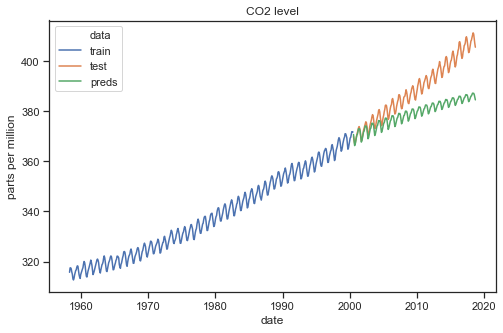

In [253]:
plt.figure(figsize=(8,5))

ax = sns.lineplot(x='date', y='co2', hue='data', data=plot_df)

ax.set(title='CO2 level')
ax.set(ylabel='parts per million');

In [260]:
from sklearn.metrics import mean_squared_error

In [261]:
mean_squared_error(y_test.values, preds)

4.271876363592099

In [262]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,13,4):
                try:
                    print(f'Attempting to fit SARIMAX(1,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = y_train.astype(float).dropna(),
                                     order = (1, 1, 0),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)) 
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=datetime(2000, 7, 31),
                                          end=datetime(2018, 9, 30))

                    # Evaluate predictions.
                    rmse = mean_squared_error(y_test.values, preds) ** 0.5
                    print(f'The RMSE for (1, 1, 0)x({P},{D},{Q},{S}) is: {rmse}')

                    # Save for final report.
                    if best_mse > mean_squared_error(y_test, preds):
                        best_mse = mean_squared_error(y_test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'SARIMAX(1, 1, 1)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(1,1,0)x(0,0,0,0)
The RMSE for (1, 1, 0)x(0,0,0,0) is: 20.164158151766028
Attempting to fit SARIMAX(1,1,0)x(0,0,0,4)
The RMSE for (1, 1, 0)x(0,0,0,4) is: 20.164158151766028
Attempting to fit SARIMAX(1,1,0)x(0,0,0,8)
The RMSE for (1, 1, 0)x(0,0,0,8) is: 20.164158151766028
Attempting to fit SARIMAX(1,1,0)x(0,0,0,12)
The RMSE for (1, 1, 0)x(0,0,0,12) is: 20.164158151766028
Attempting to fit SARIMAX(1,1,0)x(0,1,0,0)
Attempting to fit SARIMAX(1,1,0)x(0,1,0,4)
The RMSE for (1, 1, 0)x(0,1,0,4) is: 37.966056830046774
Attempting to fit SARIMAX(1,1,0)x(0,1,0,8)
The RMSE for (1, 1, 0)x(0,1,0,8) is: 62.55716518620318
Attempting to fit SARIMAX(1,1,0)x(0,1,0,12)
The RMSE for (1, 1, 0)x(0,1,0,12) is: 9.358367091107278
Attempting to fit SARIMAX(1,1,0)x(0,2,0,0)
Attempting to fit SARIMAX(1,1,0)x(0,2,0,4)
The RMSE for (1, 1, 0)x(0,2,0,4) is: 1008.1183881416472
Attempting to fit SARIMAX(1,1,0)x(0,2,0,8)
The RMSE for (1, 1, 0)x(0,2,0,8) is: 1785.2370185538416
Attempting to fit SAR

/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(0,2,1,4) is: 13.529813130393283
Attempting to fit SARIMAX(1,1,0)x(0,2,1,8)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(0,2,1,8) is: 80.70223984133362
Attempting to fit SARIMAX(1,1,0)x(0,2,1,12)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(0,2,1,12) is: 8.6915365346113
Attempting to fit SARIMAX(1,1,0)x(0,0,2,0)
The RMSE for (1, 1, 0)x(0,0,2,0) is: 20.078160720857856
Attempting to fit SARIMAX(1,1,0)x(0,0,2,4)
The RMSE for (1, 1, 0)x(0,0,2,4) is: 21.010091271878444
Attempting to fit SARIMAX(1,1,0)x(0,0,2,8)
The RMSE for (1, 1, 0)x(0,0,2,8) is: 22.246045272822933
Attempting to fit SARIMAX(1,1,0)x(0,0,2,12)
The RMSE for (1, 1, 0)x(0,0,2,12) is: 19.838523519740264
Attempting to fit SARIMAX(1,1,0)x(0,1,2,0)
Attempting to fit SARIMAX(1,1,0)x(0,1,2,4)
The RMSE for (1, 1, 0)x(0,1,2,4) is: 5.232453193218486
Attempting to fit SARIMAX(1,1,0)x(0,1,2,8)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(0,1,2,8) is: 5.030248623099702
Attempting to fit SARIMAX(1,1,0)x(0,1,2,12)
The RMSE for (1, 1, 0)x(0,1,2,12) is: 6.030858419335544
Attempting to fit SARIMAX(1,1,0)x(0,2,2,0)
Attempting to fit SARIMAX(1,1,0)x(0,2,2,4)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(0,2,2,4) is: 2.4025565602379055
Attempting to fit SARIMAX(1,1,0)x(0,2,2,8)
The RMSE for (1, 1, 0)x(0,2,2,8) is: 3.176305097607399
Attempting to fit SARIMAX(1,1,0)x(0,2,2,12)
The RMSE for (1, 1, 0)x(0,2,2,12) is: 2.1419979112805114
Attempting to fit SARIMAX(1,1,0)x(1,0,0,0)
The RMSE for (1, 1, 0)x(1,0,0,0) is: 19.972256396912645
Attempting to fit SARIMAX(1,1,0)x(1,0,0,4)
The RMSE for (1, 1, 0)x(1,0,0,4) is: 20.606907987313605
Attempting to fit SARIMAX(1,1,0)x(1,0,0,8)
The RMSE for (1, 1, 0)x(1,0,0,8) is: 21.372836617476793
Attempting to fit SARIMAX(1,1,0)x(1,0,0,12)
The RMSE for (1, 1, 0)x(1,0,0,12) is: 11.717044470636464
Attempting to fit SARIMAX(1,1,0)x(1,1,0,0)
Attempting to fit SARIMAX(1,1,0)x(1,1,0,4)
The RMSE for (1, 1, 0)x(1,1,0,4) is: 54.24086187597108
Attempting to fit SARIMAX(1,1,0)x(1,1,0,8)
The RMSE for (1, 1, 0)x(1,1,0,8) is: 10.251445032460126
Attempting to fit SARIMAX(1,1,0)x(1,1,0,12)
The RMSE for (1, 1, 0)x(1,1,0,12) is: 8.804279394388642
Attempt

/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(1,1,2,8) is: 5.178520826859746
Attempting to fit SARIMAX(1,1,0)x(1,1,2,12)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The RMSE for (1, 1, 0)x(1,1,2,12) is: 6.028666161260928
Attempting to fit SARIMAX(1,1,0)x(1,2,2,0)
Attempting to fit SARIMAX(1,1,0)x(1,2,2,4)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(1,2,2,4) is: 18.260114458213035
Attempting to fit SARIMAX(1,1,0)x(1,2,2,8)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(1,2,2,8) is: 104.8975411756565
Attempting to fit SARIMAX(1,1,0)x(1,2,2,12)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


The RMSE for (1, 1, 0)x(1,2,2,12) is: 2.0798220172734423
Attempting to fit SARIMAX(1,1,0)x(2,0,0,0)
The RMSE for (1, 1, 0)x(2,0,0,0) is: 20.684238022164934
Attempting to fit SARIMAX(1,1,0)x(2,0,0,4)
The RMSE for (1, 1, 0)x(2,0,0,4) is: 22.430572614960806
Attempting to fit SARIMAX(1,1,0)x(2,0,0,8)
The RMSE for (1, 1, 0)x(2,0,0,8) is: 22.466410933102207
Attempting to fit SARIMAX(1,1,0)x(2,0,0,12)
The RMSE for (1, 1, 0)x(2,0,0,12) is: 9.859917818376921
Attempting to fit SARIMAX(1,1,0)x(2,1,0,0)
Attempting to fit SARIMAX(1,1,0)x(2,1,0,4)
The RMSE for (1, 1, 0)x(2,1,0,4) is: 8.446876751025465
Attempting to fit SARIMAX(1,1,0)x(2,1,0,8)
The RMSE for (1, 1, 0)x(2,1,0,8) is: 7.929057888410623
Attempting to fit SARIMAX(1,1,0)x(2,1,0,12)
The RMSE for (1, 1, 0)x(2,1,0,12) is: 4.885300231228409
Attempting to fit SARIMAX(1,1,0)x(2,2,0,0)
Attempting to fit SARIMAX(1,1,0)x(2,2,0,4)
The RMSE for (1, 1, 0)x(2,2,0,4) is: 174.23662734298566
Attempting to fit SARIMAX(1,1,0)x(2,2,0,8)
The RMSE for (1, 1, 0)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The RMSE for (1, 1, 0)x(2,2,1,8) is: 6.929481719380702
Attempting to fit SARIMAX(1,1,0)x(2,2,1,12)
The RMSE for (1, 1, 0)x(2,2,1,12) is: 3.384544893327207
Attempting to fit SARIMAX(1,1,0)x(2,0,2,0)
The RMSE for (1, 1, 0)x(2,0,2,0) is: 21.359860175343943
Attempting to fit SARIMAX(1,1,0)x(2,0,2,4)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The RMSE for (1, 1, 0)x(2,0,2,4) is: 22.34291485439802
Attempting to fit SARIMAX(1,1,0)x(2,0,2,8)
The RMSE for (1, 1, 0)x(2,0,2,8) is: 22.266662608615025
Attempting to fit SARIMAX(1,1,0)x(2,0,2,12)
The RMSE for (1, 1, 0)x(2,0,2,12) is: 6.088273661697741
Attempting to fit SARIMAX(1,1,0)x(2,1,2,0)
Attempting to fit SARIMAX(1,1,0)x(2,1,2,4)
The RMSE for (1, 1, 0)x(2,1,2,4) is: 6.181059866528459
Attempting to fit SARIMAX(1,1,0)x(2,1,2,8)
The RMSE for (1, 1, 0)x(2,1,2,8) is: 3.6476235789688105
Attempting to fit SARIMAX(1,1,0)x(2,1,2,12)
The RMSE for (1, 1, 0)x(2,1,2,12) is: 5.860155891011038
Attempting to fit SARIMAX(1,1,0)x(2,2,2,0)
Attempting to fit SARIMAX(1,1,0)x(2,2,2,4)
The RMSE for (1, 1, 0)x(2,2,2,4) is: 7.432551611594314
Attempting to fit SARIMAX(1,1,0)x(2,2,2,8)


/Users/Jelly/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The RMSE for (1, 1, 0)x(2,2,2,8) is: 6.8185403997383744
Attempting to fit SARIMAX(1,1,0)x(2,2,2,12)
The RMSE for (1, 1, 0)x(2,2,2,12) is: 2.066851800103747
Our model that minimizes MSE on the testing data is the SARIMAX(0, 2, 1)x(2,2,2,12).
This model has an MSE of 4.271876363592099.


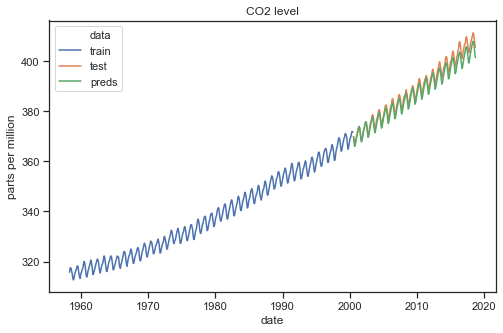

In [263]:
sarima = SARIMAX(endog = y_train.astype(float).dropna(),
                 order = (1, 1, 0),
                 seasonal_order = (2, 2, 2, 12))

model = sarima.fit()

preds = model.predict(start=datetime(2000, 7, 31),
                      end=datetime(2018, 9, 30))

train_df = pd.DataFrame(columns=['date', 'co2', 'data'])
train_df['date'] = pd.to_datetime(X_train, format='%Y-%m-%d')
train_df['co2'] = y_train.values
train_df['data'] = 'train'

test_df = pd.DataFrame(columns=['date', 'co2', 'data'])
test_df['date'] = pd.to_datetime(X_test, format='%Y-%m-%d')
test_df['co2'] = y_test.values
test_df['data'] = 'test'

preds_df = pd.DataFrame(columns=['date', 'co2', 'data'])
preds_df['date'] = pd.to_datetime(X_test, format='%Y-%m-%d')
preds_df['co2'] = preds.values
preds_df['data'] = 'preds'

plot_df = pd.concat([train_df, test_df, preds_df], axis=0)
plot_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8,5))

ax = sns.lineplot(x='date', y='co2', hue='data', data=plot_df)

ax.set(title='CO2 level')
ax.set(ylabel='parts per million');

In [95]:
from scipy.stats import ttest_ind_from_stats

In [96]:
ttest_ind_from_stats(1100, 165, 140, 1200, 135, 80)

Ttest_indResult(statistic=-4.609164998509353, pvalue=6.881626543532403e-06)